In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 6})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


# 1s data set

In [21]:
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
errors_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_errors_sum_bin.pkl'
ids_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'

with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids = pickle.load(f)


# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

In [3]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [5]:
# load light curve segments
with open('{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5"
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 20 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [6]:
GMmodel_1s_labels = GMmodel_1s.predict(shape_moments)

In [8]:
GMmodel_1s.means_.shape

(222, 24)

In [10]:
umap_transformer = umap.UMAP(random_state=0).fit(GMmodel_1s.means_)

In [351]:
len([20,23,28,40,47,53,58,69,83,102,116,137,178,196,201])

15

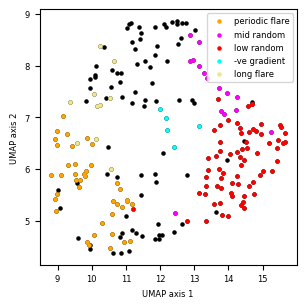

In [347]:
plt.rcParams['figure.figsize'] = (3.32,3.32)
plt.rcParams.update({'font.size': 6})


embedding = umap_transformer.embedding_

zorders = [-1]*122
labels = ["Other"]*122

s=5

plt.scatter(embedding[:,0], embedding[:,1], c="black", s=s)


filter_indices = [13,16,19,29,34,39,44,46,49,52,55,77,78,81,86,105,107,108,117,124,130,141,151,155,157,159,160,165,166,169,170,
172,177,185,186,187,189,190,206,213,218,219]# regular peaks

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="orange", label= "periodic flare", s=s)


colour_filter = ["orange" if x in filter_indices else "black" for x in range(122)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Periodic flare" if ind in filter_indices else x for ind, x in enumerate(zorders)]

filter_indices = [20,23,28,40,47,53,58,69,83,102,116,137,178,196,201]# mid-flats

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="magenta", label= "mid random", s=s)


colour_filter = ["magenta" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Mid random" if ind in filter_indices else x for ind, x in enumerate(zorders)]

filter_indices = [0, 1, 2,3,4,7,8,9,12,14,15,17,18,27,31,35,36,41,42,48,51,54,60,61,64,65,66,75,82,84,85,88,89,90,94,100,106,
110,112,113,120,122,123,126,127,132,145,146,147,148,152,154,157,161,162,164,171,173,176,176,193,194,202,203,
204,207,208,211,212]# low-flats

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="red", label= "low random", s=s)


filter_indices = [10,11,21,199, 68]# -ve grad

plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="cyan", label= "-ve gradient", s=s)

filter_indices = [6,33,57,67,97,104,119,131,158,205]
plt.scatter(embedding[filter_indices,0], embedding[filter_indices,1], c="khaki", label= "long flare", s=s)

colour_filter = ["cyan" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]
zorders = [1 if ind in filter_indices else x for ind, x in enumerate(zorders)]
labels = ["Low random" if ind in filter_indices else x for ind, x in enumerate(zorders)]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

# filter_indices = [19,34,39,70]# irregular peaks

# colour_filter = ["red" if ind in filter_indices else x for ind, x in enumerate(colour_filter)]

# plt.scatter(embedding[:,0], embedding[:,1], c=colour_filter)
plt.legend()
plt.savefig('figures/UMAP_component_means_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)


plt.show()

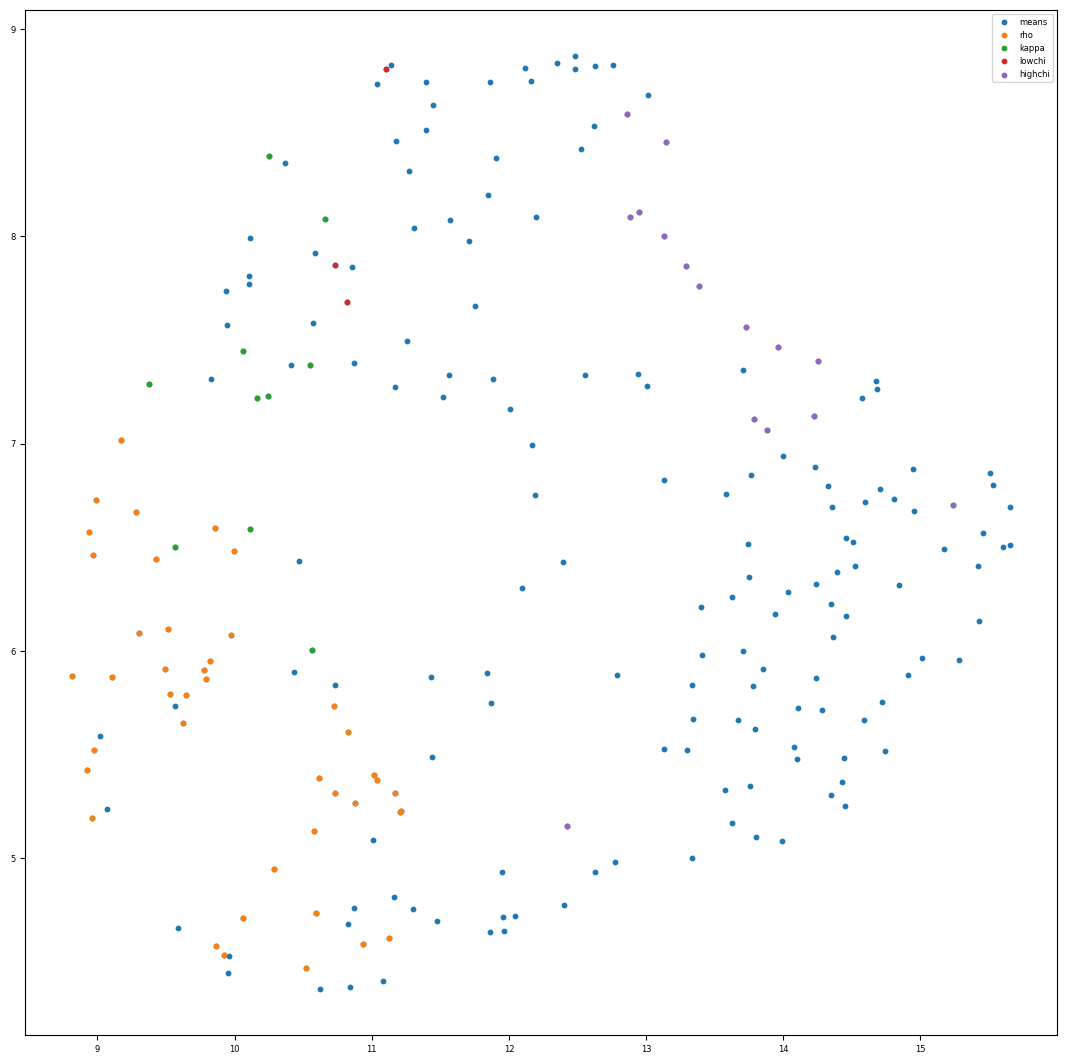

In [320]:
plt.rcParams['figure.figsize'] = (13.32, 13.32)#6.97)
plt.rcParams.update({'font.size': 6})

rho = [13,16,19,29,34,39,44,46,49,52,55,77,78,81,86,105,107,108,117,124,130,141,151,155,157,159,160,165,166,169,170, 172,177,185,186,187,189,190,206,213,218,219]
kappa = [6,33,57,67,97,104,119,131,158,205]
lowchi = [174,188,22]

highchi = [20,23,28,40,47,53,58,69,83,102,116,137,178,196,201]

plt.scatter(umap_transformer.embedding_[:, 0], umap_transformer.embedding_[:, 1],s=10,zorder=2, label="means")
plt.scatter(umap_transformer.embedding_[rho, 0], umap_transformer.embedding_[rho, 1],s=10,zorder=2, label="rho")
plt.scatter(umap_transformer.embedding_[kappa, 0], umap_transformer.embedding_[kappa, 1],s=10,zorder=2, label="kappa")
plt.scatter(umap_transformer.embedding_[lowchi, 0], umap_transformer.embedding_[lowchi, 1],s=10,zorder=2, label="lowchi")
plt.scatter(umap_transformer.embedding_[highchi, 0], umap_transformer.embedding_[highchi, 1],s=10,zorder=2, label="highchi")



lgnd = plt.legend(fontsize=6)

# #change the marker size manually for both lines
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# lgnd.legendHandles[2]._sizes = [30]
# lgnd.legendHandles[3]._sizes = [30]

# plt.xlabel("UMAP axis 1")
# plt.ylabel("UMAP axis 2")

# plt.savefig('figures/UMAP_IFoS_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.05)


plt.show()

In [296]:
component_n = 0

47


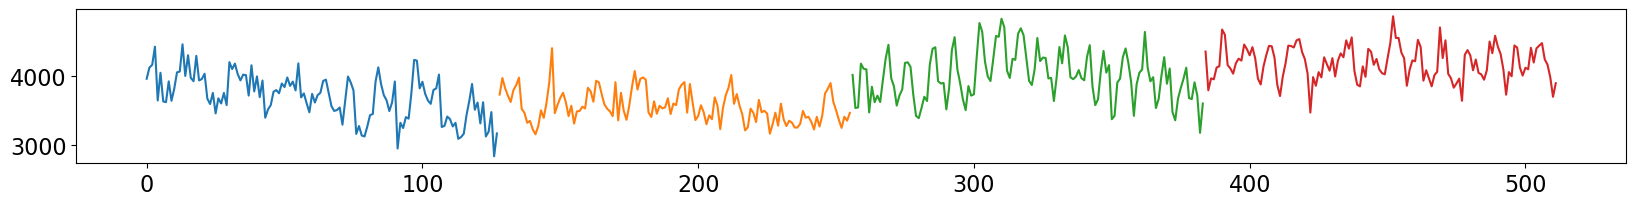

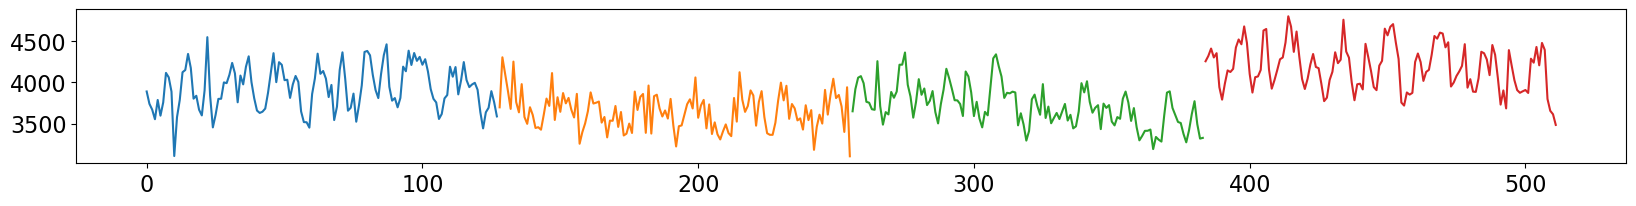

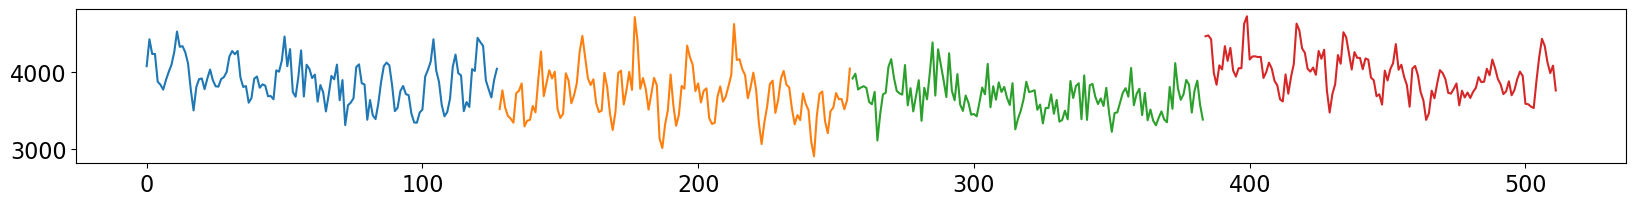

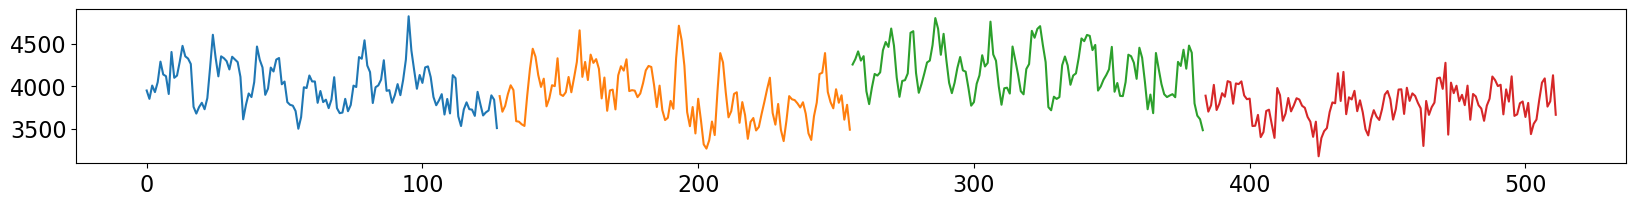

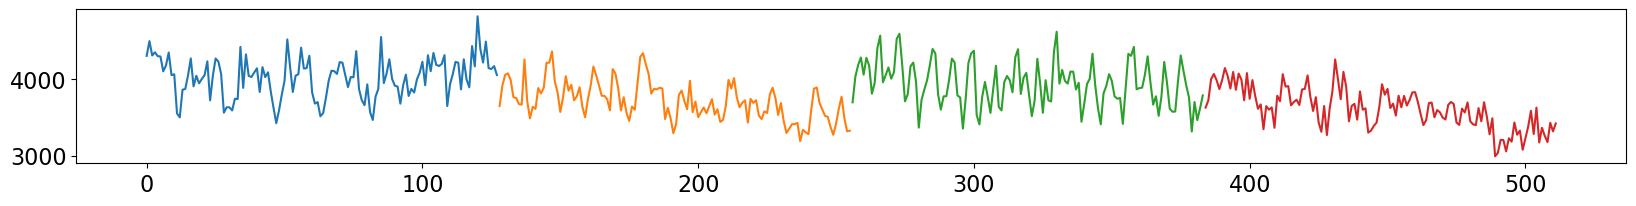

In [345]:
plt.rcParams['figure.figsize'] = (20.0, 2.0)
plt.rcParams.update({'font.size': 16})


data_indices = np.where(GMmodel_1s_labels == component_n)[0]

print(component_n)

for seg_index in range(5):
    seg_index+=5
    plt.plot(np.arange(128),segments[data_indices[seg_index]])
    plt.plot(np.arange(128)+128,segments[data_indices[seg_index*2]])
    plt.plot(np.arange(128)+128*2,segments[data_indices[seg_index*3]])
    plt.plot(np.arange(128)+128*3,segments[data_indices[seg_index*4]])
    plt.show()
    
component_n+=1

In [353]:
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids]

In [359]:
recos_dir = "{}/reconstructions_model_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir)
with open(recos_dir, 'rb') as f:
    recos = pickle.load(f)
recos= recos*np.std(segments, axis=1) + np.mean(segments, axis=1)

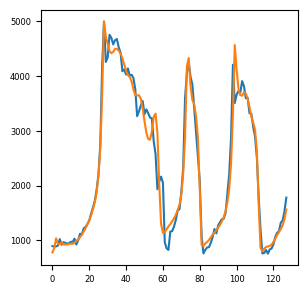

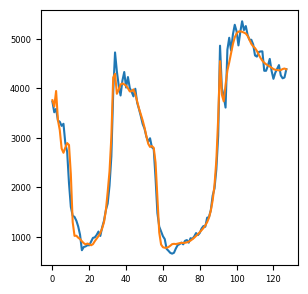

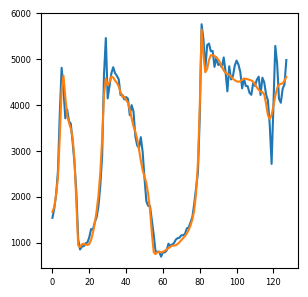

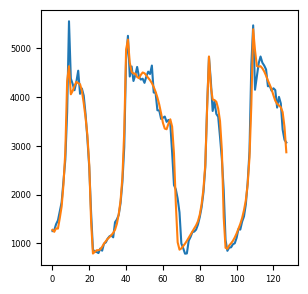

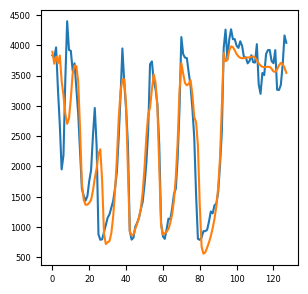

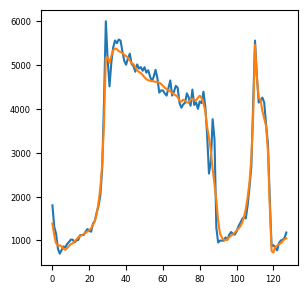

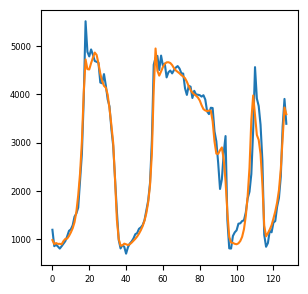

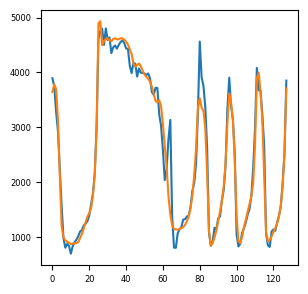

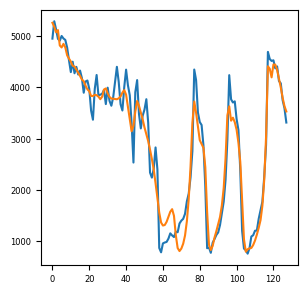

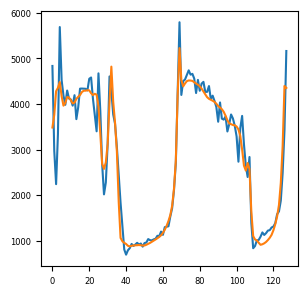

In [362]:
for seg_oi in np.where(np.array(seg_ObIDs) == "40703-01-26-00")[0][:10]:
    plt.plot(np.arange(128),segments[seg_oi])
    plt.plot(np.arange(128),recos[seg_oi])
    plt.show()